# Final Assignment
## __Machine Learning and Neural Networks__

## Introduction

In this assignment I will be doing image classification using the CIFAR-10 dataset that is available as part of the Keras library.
Our input consists of 60000 32x32 colour images (3 channels) in 10 classes, with 6000 images per class.
There are 50000 training images and 10000 test images [1].
This is a multiclass, single-label classification and our labels can have the following classes:

| Label | Description  |
| ----- |--------------|
| 0     | airplane     |
| 1     | automobile   |
| 2     | bird         |
| 3     | cat          |
| 4     | deer         |
| 5     | dog          |
| 6     | frog         |
| 7     | horse        |
| 8     | ship         |
| 9     | truck        |

My hypothesis is that we have enough samples (60000) to predict with high accuracy (>90%) the label of each image.
Because each class has the same number of samples we have a balanced-classification problem.
Therefore accuracy and AUC (Area Under The Curve) ROC (Receiver Operating Characteristics) curves will serve to
measure our models result.

@TODO remove ---
Credit will be awarded for (up to 70 marks):

- report structure and quality as a document (avoid excessive repetition)
- adherence to the DL workflow
- a systematic investigation
- interpretation of results

Extra credit may be given for (up to 30 marks):

- clean, modular code
- a dataset other than the ones mentioned above
- extremely thorough examination of a series of models on a single dataset
- any work or demonstrable DL understanding that reaches beyond the topics and concepts discussed so far
---


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
X_train shape: (50000, 32, 32, 3)
Train sample count: 50000
Test sample count: 10000
Classes available: [0 1 2 3 4 5 6 7 8 9]
Example images


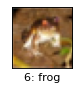

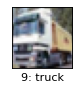

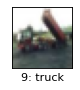

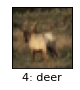

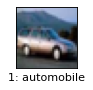

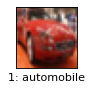

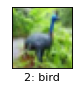

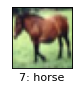

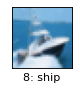

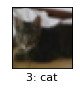

In [18]:
%load_ext autoreload
%autoreload 2

import tensorflow.keras as keras
from keras.datasets import cifar10
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import layers

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('X_train shape:', X_train.shape)
print('Train sample count:', X_train.shape[0])
print('Test sample count:', X_test.shape[0])
print('Classes available:', np.unique(y_train[:, :]))


In [ ]:
# Plot functions

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def plot_loss_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


def plot_image(x, y, label_names):
    figure(figsize=(1,1 ), dpi=80)
    plt.imshow(x)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(str(y[0]) + ": " + label_names[y[0]])
    plt.show()

print('Example images')

label_names = ["airplane","automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

for idx in range(10):
    plot_image(X_train[idx], y_train[idx], label_names)

## Methodology

### Dumb baseline

Our first step is to create a small model to validate that our samples have statistical power.
Even a basic model should have results better than an random guess.
A random guess would be correct around 10% of the time since we have 10 different classes.

In [19]:
classes = np.unique(y_train[:, :])
num_classes = classes.shape[0]

guess_accuracy = 1 / num_classes

print("Number of classes: ", num_classes)
print("Dumb baseline accuracy: ", guess_accuracy)

Number of classes:  10
Dumb baseline accuracy:  0.1


### Preprocessing

#### One-hot encoding
To build our first model we need first to one-hot encode "y".
The labels array "y" represents each label as a integer ranging from 0 to 9.
We can't use integers in our classification, we need to transform "y" into array with shape (number of samples, number of classes)
containing only zeros and ones.

#### Normalizing
It's not a good practice to use large values as input data into a artificial neural network.
Each pixel of the input images has three values ranging from 0 to 255 representing the channels red, green, blue.
Before feeding this data into the neural network, I am dividing each channel by 255 to get values ranging from 0 to 1.
Normalizing avoid problems with the gradient updates that can prevent our model to converge to the minimum loss [3].
I am also converting the input values to "float32" arrays to fit Tensorflow expectations and avoid compilation problems.


In [20]:
def encode_norm(X, y, num_classes):
    y = keras.utils.to_categorical(y, num_classes)
    X = X.astype('float32')
    X = X.astype('float32')
    X /= 255
    return X, y

X_train, y_train = encode_norm(X_train, y_train, num_classes)
X_test, y_test = encode_norm(X_test, y_test, num_classes)

input_shape = X_train.shape[1:]

### Model base architecture

#### Last layer activation function

I will be using "softmax" activation in all model tests.
Softmax is indicated when we have a multilabel classification with a single category as output [4].
The values returned by this function represent a distribution of probabilities between each category that sum to 1.
The predicted category is the one with the highest probability among the values returned.

#### Loss function

The loss function I am using is the categorical crossentropy function:

$Loss = - \sum_{i=1}^{n_c} y_i * \log \hat{y_i} $

where $\hat{y_i}$ is each predicted label probability, $y_i$ is the real label probability and $c_n$ is the number of classes.
Categorical crossentropy is a good fit when we have a discrete probability distribution and we want to know how "far" is this
distribution from another one [5].

###  The "build_and_run_model" function

Below I created a function that takes a Keras model and completes it by adding the last layer and defining the loss function and optimizer.
This function also runs the model and returns information about its performance.

In [21]:
def build_and_run_model(model, epochs, batch_size, input_shape=None):
    validation_split = 0.2

    if (input_shape is None):
        model.add(layers.Flatten())
    else:
        model.add(layers.Flatten(input_shape=input_shape))

    model.add(layers.Dense(num_classes, activation="softmax"))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.RMSprop(),
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=epochs, validation_split=validation_split, batch_size=batch_size)
    plot_loss_history(history)
    scores = model.evaluate(X_test, y_test, verbose=1)
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])


### Basic model

Below I created and ran the simplest possible model to check if our samples have statistical power and provide better results than a guess with 10% accuracy.
This model using only a dense layer achieved an accuracy of 31% proving that our samples have statistical value.
Looking at the plot relating the loss to the number of epochs, we see that the train loss and the validation loss moving average converge to a minimum value without showing signs of over-fitting.
However, we see that the model does not have sufficient __capacity__ to model the problem.
The accuracy obtained is not good enough and also the way that validation loss oscillates shows that our model needs changes to be able to generalize the problem in a consistent way.

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 3072)              0         
                                                                 
 dense_6 (Dense)             (None, 10)                30730     
                                                                 
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
400/400 [==============================] - 2s 5ms/step - loss: 2.2000 - accuracy: 0.2492 - val_loss: 1.9183 - val_accuracy: 0.3135
Epoch 2/40
400/400 [==============================] - 2s 4ms/step - loss: 2.0578 - accuracy: 0.3023 - val_loss: 2.2353 - val_accuracy: 0.2992
Epoch 3/40
400/400 [==============================] - 1s 3ms/step - loss: 2.0255 - accuracy: 0.3170 - val_loss: 2.2660 - val_accuracy: 0.2750
Epoch 4/40
400/400 [

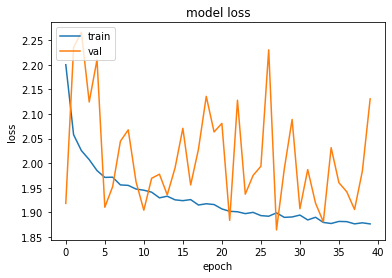

313/313 [==============================] - 1s 3ms/step - loss: 2.1138 - accuracy: 0.3165
Test loss: 2.1138076782226562
Test accuracy: 0.3165000081062317


In [22]:

model = Sequential()
build_and_run_model(model, 40, 100, input_shape=input_shape)


### Simple convolution model

In this next test we will use a convolution layer to try to better fit our model to the problem at hand.
Dense layers are good for learning general patterns about our samples.
However, images contain local patterns that have high statistical value but present themselves differently in each sample.
For example a wheel has a high value to indicate that the sample contains a vehicle.
However, this wheel can appear in different sizes and positions within the image, not allowing dense layers alone to capture this pattern.
Convolution layers have the following features that are useful to us:
- Patterns learned are not affected by the position where they appears in the image
- When using multiple convolution layers, our model can learn hierarchies of patters where a second layer can learn large patters on top of the patters of the first layert


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 10)                81930     
                                                                 
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
400/400 [==============================] - 28s 67ms/step - loss: 1.6821 - accuracy: 0.4086 - val_loss: 1.

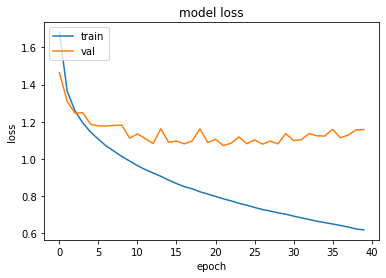

313/313 [==============================] - 3s 8ms/step - loss: 1.1561 - accuracy: 0.6281
Test loss: 1.1560769081115723
Test accuracy: 0.6280999779701233


In [24]:
model = Sequential()
model.add(layers.Conv2D(32, 3, activation="relu", padding='same', input_shape=input_shape))
model.add(layers.MaxPooling2D(2))
build_and_run_model(model, 40, 100)

## 2 layers convolution model

In this model below I am adding an additional layer of convolution to see if we can improve the model accuracy in the test samples.

In [25]:

model = Sequential()
model.add(layers.Conv2D(32, 3, activation="relu", padding='same', input_shape=input_shape))
model.add(layers.MaxPooling2D(2))
model.add(layers.Conv2D(32, 3, activation="relu", padding='same'))
model.add(layers.GlobalMaxPooling2D())
build_and_run_model(model, 40, 100)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 global_max_pooling2d_3 (Glo  (None, 32)               0         
 balMaxPooling2D)                                                
                                                                 
 flatten_9 (Flatten)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 10)               

KeyboardInterrupt: 

## Data augmentation

Using data augmentation techniques we can increase our number of images available for training. These techniques create new images from existing ones by applying resizes, translations, and mirroring. With more samples we hope to reduce the gap between training and evaluation loss.


In [ ]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

epochs = 40
batch_size = 100

datagen.fit(X_train)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:
model.fit(datagen.flow(X_train, y_train, batch_size=batch_size,
                       subset='training'),
          validation_data=datagen.flow(X_train, y_train,
                                       batch_size=8, subset='validation'),
          steps_per_epoch=len(X_train) / batch_size, epochs=epochs)
# here's a more "manual" example
for e in range(epochs):
    print('Epoch', e)
    batches = 0
    for x_batch, y_batch in datagen.flow(X_train, y_train, batch_size=batch_size):
        model.fit(x_batch, y_batch)
        batches += 1
        if batches >= len(X_train) / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

## Hyperparameters tunning


## Results

## Conclusions

## References

[1] https://www.cs.toronto.edu/~kriz/cifar.html
[2] Book 4.5.2 Choosing a measure of success
[3] Book 4.3.1 Data preprocessing for neural networks
[4] https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy
[5] https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/categorical-crossentropy
[6] Book 5.1.1